## Imports

In [26]:
# from nb_utils import set_root
# PROJECT_DIR = set_root(3)
# print("PROJECT_DIR: " + str(PROJECT_DIR))

In [1]:
from mlpr.ml.supervisioned.regression import metrics, plots
from mlpr.ml.tunning.grid_search import GridSearch
from mlpr.reports.create import ReportGenerator

from utils.reader import read_file_yaml

import pandas as pd
import numpy as np
import sklearn.datasets as sk_datasets
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

%reload_ext autoreload

## Parameters

In [25]:
path_data = PROJECT_DIR  / 'data'
path_conf = PROJECT_DIR  / 'conf'
path_templates = PROJECT_DIR / 'templates'
path_assets = PROJECT_DIR / 'assets'

path_intermediate = path_data / '02_intermediate'
path_models = path_data / '04_models'
path_reports = path_data / '05_reports'

path_reports_regression = path_templates / "regression"
file_path_reports = path_reports / "report_model.html"

parameters = read_file_yaml(path_conf / 'params.yaml')

datasets = parameters["datasets"]
n_seed = parameters["experiments"]["n_seed"]

PosixPath('/home/manuel/Documents/projects/libs/mlpr')

In [24]:
np.random.seed(n_seed)

## Read

In [7]:
content = getattr(sk_datasets, datasets["diabetes"]["path"])()
data = pd.DataFrame(content["data"], columns=content["feature_names"])
data["target"] = content["target"]

## Split labels

In [8]:
X = data.drop("target", axis=1)
y = data["target"].values

## Modelling

In [9]:
models_params = {
    Ridge: {'alpha': [0.1, 1.0, 10.0], 'random_state': [n_seed]},
    Lasso: {'alpha': [0.1, 1.0, 10.0], 'random_state': [n_seed]},
    SVR: {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']},
    RandomForestRegressor: {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10], 'random_state': [n_seed]},
    GradientBoostingRegressor: {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05, 0.01], 'random_state': [n_seed]},
    XGBRegressor: {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05, 0.01], 'random_state': [n_seed]}
}

params_split = {'test_size': 0.25, 'random_state': n_seed}
params_norm = {'with_mean': True, 'with_std': True}

grid_search = GridSearch(
    X,
    y,
    params_split=params_split,
    models_params=models_params,
    normalize=True,
    params_norm=params_norm
    )
grid_search.search()

best_model, best_params = \
    grid_search \
        .get_best_model()


## Predictions

In [10]:
data_test = pd.DataFrame(
    grid_search.X_train,
    columns=X.columns
)
data_test["y_true"] = grid_search.y_train
data_test["y_pred"] = grid_search.best_model.predict(grid_search.X_train)

In [11]:
rp = plots.RegressionPlots(data_test, color_palette=["#FF4B3E", "#1C2127"])

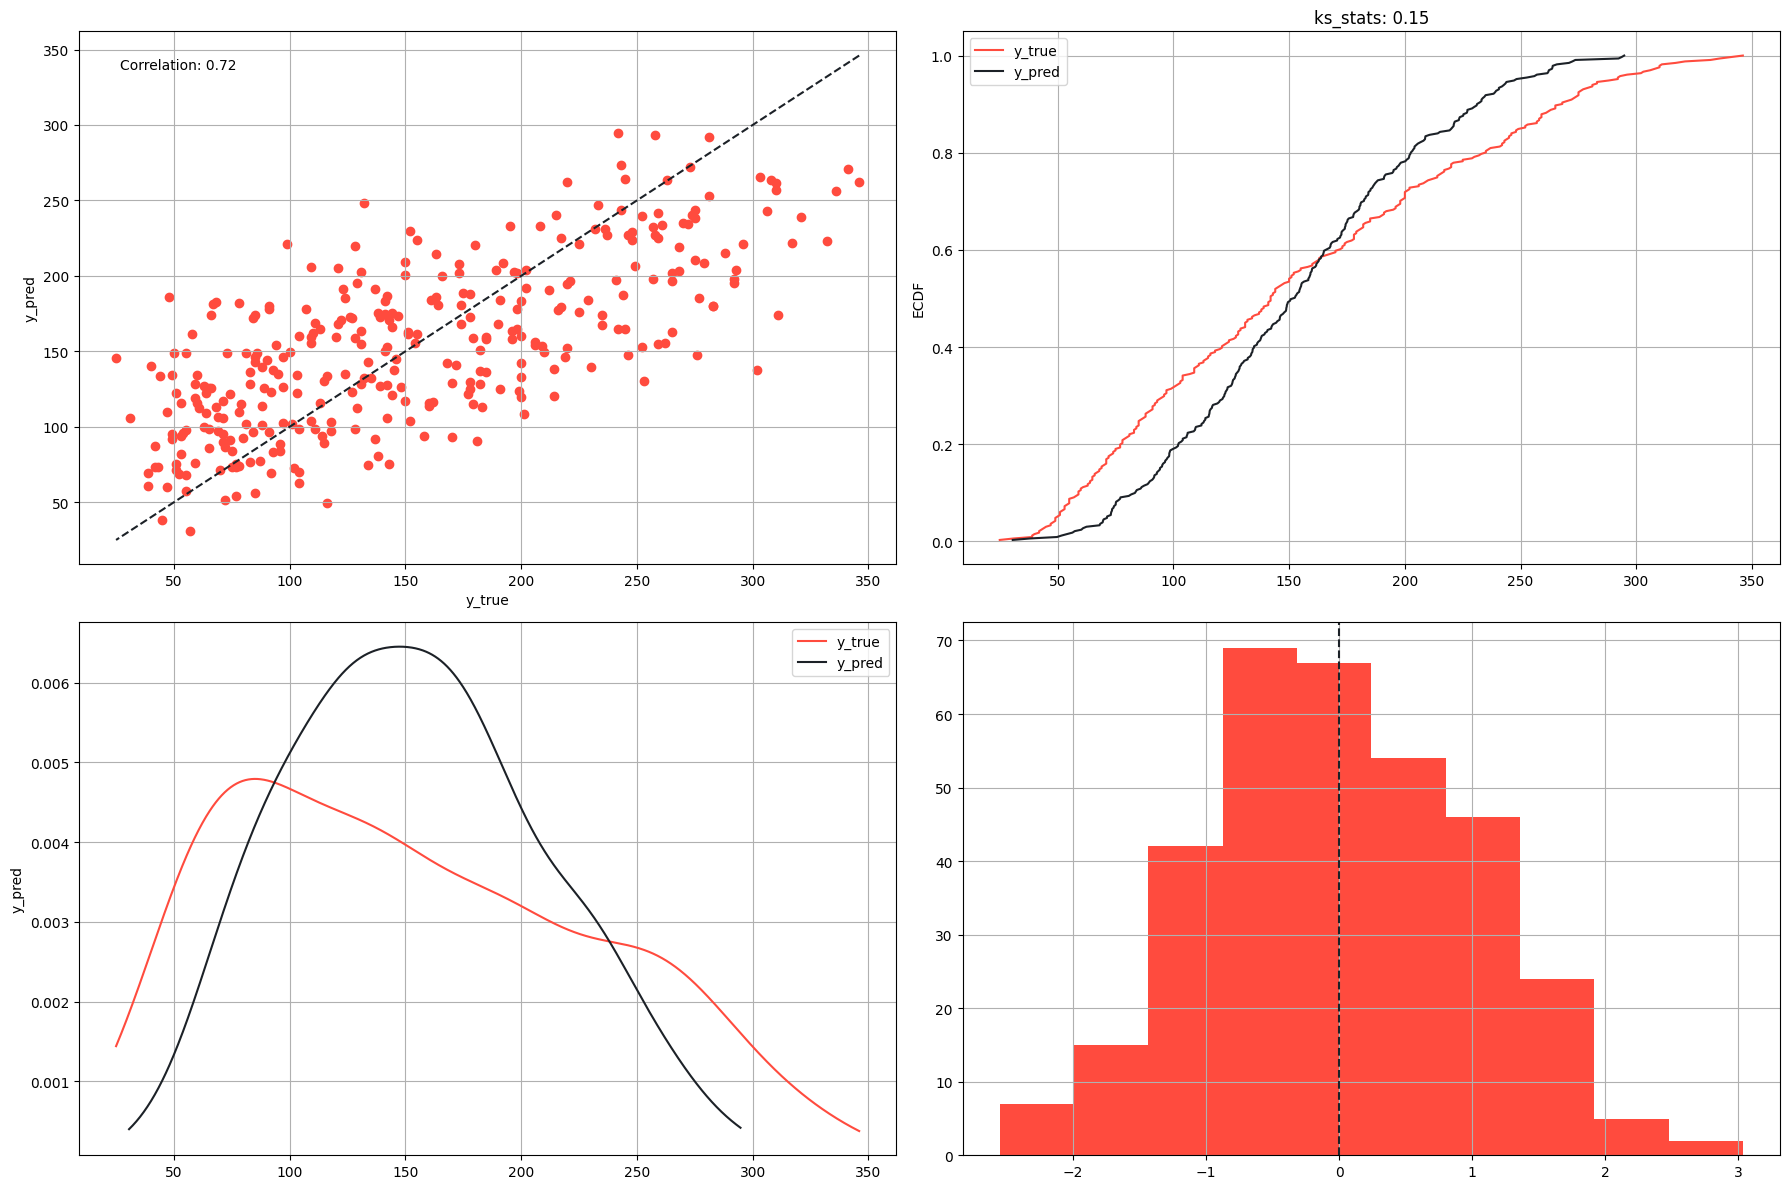

In [19]:
fig, axs = rp.grid_plot(
    plot_functions=[
        ['scatter', 'plot_ecdf'],
        ['plot_kde', 'plot_error_hist']
    ],
    plot_args={
        'scatter': {'y_true_col': 'y_true', 'y_pred_col': 'y_pred', 'linecolor': '#1C2127'},
        'plot_ecdf': {'y_true_col': 'y_true', 'y_pred_col': 'y_pred'},
        'plot_kde': {'columns': ['y_true', 'y_pred']},
        'plot_error_hist': {'y_true_col': 'y_true', 'y_pred_col': 'y_pred', 'linecolor': '#1C2127'}
    },
    show_inline=True
)

## Metrics

In [13]:
k = 4
rm = metrics.RegressionMetrics(data_test, *["y_true", "y_pred"])

In [14]:
results = rm.calculate_metrics(
    ["mape", "rmse", "kolmogorov_smirnov", "confusion_matrix", "calculate_kappa"],
    {
        "mape": {},
        "rmse": {},
        "kolmogorov_smirnov": {},
        "confusion_matrix": {"n_bins": k},
        "calculate_kappa": {"n_bins": k}
    }
)

## Save image

In [15]:
fig.savefig(
    path_assets / "regression_plots.png",
    dpi=400,
    bbox_inches='tight'
)

## Reports

In [16]:
report = ReportGenerator(template_dir = path_reports_regression)
report.render(
    metrics=results,
    template_file="template_v3.html",
    output_file=file_path_reports,
    image_path=path_intermediate / "regression_plots.png"
)

'Report created successfully.'

In [17]:
results

{'mape': 39.594540526956436,
 'rmse': 54.09419440169204,
 'kolmogorov_smirnov': (0.1510574018126888, 0.0010310446878578096),
 'confusion_matrix': (array([[54, 57,  2,  0],
         [16, 70, 21,  0],
         [ 0, 37, 37,  3],
         [ 0,  6, 25,  3]]),
  {'precision': array([0.77142857, 0.41176471, 0.43529412, 0.5       ]),
   'recall': array([0.47787611, 0.65420561, 0.48051948, 0.08823529]),
   'f1_score': array([0.59016393, 0.50541516, 0.45679012, 0.15      ]),
   'support': array([113, 107,  77,  34]),
   'accuracy': 0.4954682779456193}),
 'calculate_kappa': {0: {'confusion_matrix': array([[202,  16],
          [ 59,  54]]),
   'kappa_score': 0.4452885840055415,
   'metrics': {'precision': array([0.77394636, 0.77142857]),
    'recall': array([0.9266055 , 0.47787611]),
    'f1_score': array([0.8434238 , 0.59016393]),
    'support': array([218, 113]),
    'accuracy': 0.7734138972809668}},
  1: {'confusion_matrix': array([[124, 100],
          [ 37,  70]]),
   'kappa_score': 0.180085